In [1]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import sys
import IPython.display as ipd  # To play sound in the notebook
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-02-02-01-01.wav
1,male_surprise,RAVDESS,data/RAVDESS/Actor_01/03-01-08-01-01-01-01.wav
2,male_angry,RAVDESS,data/RAVDESS/Actor_01/03-01-05-01-02-01-01.wav
3,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-01-02-02-01.wav
4,male_fear,RAVDESS,data/RAVDESS/Actor_01/03-01-06-02-01-02-01.wav


In [3]:
'''
1. Data Augmentation method   
'''
def speedNpitch(data):
    """
    Speed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

'''
2. Extracting the MFCC feature as an image (Matrix format).  
'''
def prepare_data(df, n, aug, mfcc):
    X = np.empty(shape=(df.shape[0], n, 216, 1))
    input_length = sampling_rate * audio_duration
    
    cnt = 0
    for fname in tqdm(df.path):
        file_path = fname
        data, _ = librosa.load(file_path, sr=sampling_rate
                               ,res_type="kaiser_fast"
                               ,duration=2.5
                               ,offset=0.5
                              ) 
        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")
            
        if aug == 1:
            data = speedNpitch(data)
        
        # which feature?
        if mfcc == 1:
            # MFCC extraction 
            MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n)
            MFCC = np.expand_dims(MFCC, axis=-1)
            X[cnt,] = MFCC
            
        cnt += 1
    
    return X


'''
3. Confusion matrix plot 
'''        
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
'''
# 4. Create the 2D CNN model 
'''
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 16
    inp = Input(shape=(n,216,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32,(4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32,(4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32,(4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32,(4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    opt = optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    model.summary()
    # Save model and weights
    model_name = 'Emotion_Model_CNN2D.h5'
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Save model and weights at %s ' % model_path)

    # Save the model to disk
    model_json = model.to_json()
    with open('model_json.json', "w") as json_file:
        json_file.write(model_json)
    return model

'''
# 5. Other functions 
'''
class get_results:    
    def __init__(self, model_history, model ,X_test, y_test, labels):
        self.model_history = model_history
        self.model = model
        self.X_test = X_test
        self.y_test = y_test             
        self.labels = labels

    def create_plot(self, model_history):
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def create_results(self, model):
        opt = optimizers.Adam(0.001)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        score = model.evaluate(X_test, y_test, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    def confusion_results(self, X_test, y_test, labels, model):
        preds = model.predict(X_test, 
                                 batch_size=16, 
                                 verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))

        classes = labels
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print_confusion_matrix(c, class_names = classes)
    
    def accuracy_results_gender(self, X_test, y_test, labels, model):    
        preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=2)
        preds=preds.argmax(axis=1)
        preds = preds.astype(int).flatten()
        preds = (lb.inverse_transform((preds)))

        actual = y_test.argmax(axis=1)
        actual = actual.astype(int).flatten()
        actual = (lb.inverse_transform((actual)))
        
        # print(accuracy_score(actual, preds))
        
        actual = pd.DataFrame(actual).replace({'female_angry':'female'
                   , 'female_disgust':'female'
                   , 'female_fear':'female'
                   , 'female_happy':'female'
                   , 'female_sad':'female'
                   , 'female_surprise':'female'
                   , 'female_neutral':'female'
                   , 'male_angry':'male'
                   , 'male_fear':'male'
                   , 'male_happy':'male'
                   , 'male_sad':'male'
                   , 'male_surprise':'male'
                   , 'male_neutral':'male'
                   , 'male_disgust':'male'
                  })
        preds = pd.DataFrame(preds).replace({'female_angry':'female'
               , 'female_disgust':'female'
               , 'female_fear':'female'
               , 'female_happy':'female'
               , 'female_sad':'female'
               , 'female_surprise':'female'
               , 'female_neutral':'female'
               , 'male_angry':'male'
               , 'male_fear':'male'
               , 'male_happy':'male'
               , 'male_sad':'male'
               , 'male_surprise':'male'
               , 'male_neutral':'male'
               , 'male_disgust':'male'
              })

        classes = actual.loc[:,0].unique() 
        classes.sort()    

        c = confusion_matrix(actual, preds)
        print(accuracy_score(actual, preds))
        print_confusion_matrix(c, class_names = classes)

In [4]:
sampling_rate=44100
audio_duration=2.5
n_mfcc = 30
mfcc = prepare_data(ref, n = n_mfcc, aug = 0, mfcc = 1)

# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(mfcc
                                                    , ref.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Build CNN model 
model = get_2d_conv_model(n=n_mfcc)
model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    batch_size=16, verbose = 2, epochs=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1440/1440 [01:19<00:00, 18.12it/s]
2022-12-25 23:00:47.008508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-25 23:00:47.008740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 216, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 30, 216, 32)       1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 216, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 216, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 108, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (N

2022-12-25 23:00:47.453020: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-25 23:00:47.925667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-25 23:00:51.076605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68/68 - 4s - loss: 2.7068 - acc: 0.1537 - val_loss: 2.3801 - val_acc: 0.2222 - 4s/epoch - 59ms/step
Epoch 2/100
68/68 - 2s - loss: 2.2715 - acc: 0.2519 - val_loss: 2.6628 - val_acc: 0.1139 - 2s/epoch - 34ms/step
Epoch 3/100
68/68 - 2s - loss: 2.0949 - acc: 0.3019 - val_loss: 2.4819 - val_acc: 0.1528 - 2s/epoch - 36ms/step
Epoch 4/100
68/68 - 3s - loss: 1.9325 - acc: 0.3435 - val_loss: 2.1993 - val_acc: 0.2861 - 3s/epoch - 38ms/step
Epoch 5/100
68/68 - 3s - loss: 1.7484 - acc: 0.4037 - val_loss: 1.8870 - val_acc: 0.3778 - 3s/epoch - 38ms/step
Epoch 6/100
68/68 - 3s - loss: 1.5709 - acc: 0.4667 - val_loss: 2.2925 - val_acc: 0.2500 - 3s/epoch - 38ms/step
Epoch 7/100
68/68 - 3s - loss: 1.3812 - acc: 0.5306 - val_loss: 1.7297 - val_acc: 0.3972 - 3s/epoch - 44ms/step
Epoch 8/100
68/68 - 3s - loss: 1.2763 - acc: 0.5843 - val_loss: 1.6164 - val_acc: 0.4306 - 3s/epoch - 49ms/step
Epoch 9/100
68/68 - 4s - loss: 1.1201 - acc: 0.6194 - val_loss: 1.4778 - val_acc: 0.4583 - 4s/epoch - 52ms/step
Epoc

Epoch 74/100
68/68 - 3s - loss: 0.0199 - acc: 0.9972 - val_loss: 0.8313 - val_acc: 0.7389 - 3s/epoch - 40ms/step
Epoch 75/100
68/68 - 3s - loss: 0.0157 - acc: 0.9972 - val_loss: 0.8348 - val_acc: 0.7278 - 3s/epoch - 41ms/step
Epoch 76/100
68/68 - 3s - loss: 0.0293 - acc: 0.9917 - val_loss: 0.9450 - val_acc: 0.7444 - 3s/epoch - 41ms/step
Epoch 77/100
68/68 - 3s - loss: 0.0186 - acc: 0.9972 - val_loss: 0.8425 - val_acc: 0.7444 - 3s/epoch - 41ms/step
Epoch 78/100
68/68 - 3s - loss: 0.0237 - acc: 0.9926 - val_loss: 0.8706 - val_acc: 0.7639 - 3s/epoch - 41ms/step
Epoch 79/100
68/68 - 3s - loss: 0.0314 - acc: 0.9898 - val_loss: 1.0265 - val_acc: 0.6889 - 3s/epoch - 40ms/step
Epoch 80/100
68/68 - 3s - loss: 0.0351 - acc: 0.9907 - val_loss: 1.0151 - val_acc: 0.7000 - 3s/epoch - 40ms/step
Epoch 81/100
68/68 - 3s - loss: 0.0320 - acc: 0.9907 - val_loss: 0.8929 - val_acc: 0.7333 - 3s/epoch - 40ms/step
Epoch 82/100
68/68 - 3s - loss: 0.0589 - acc: 0.9787 - val_loss: 1.3314 - val_acc: 0.6306 - 3s/e

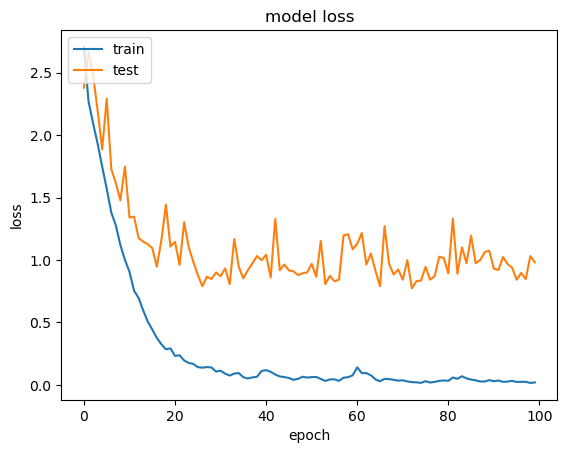

2022-12-25 23:05:26.002455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy: 73.06%


2022-12-25 23:05:26.425624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 - 0s - 365ms/epoch - 16ms/step


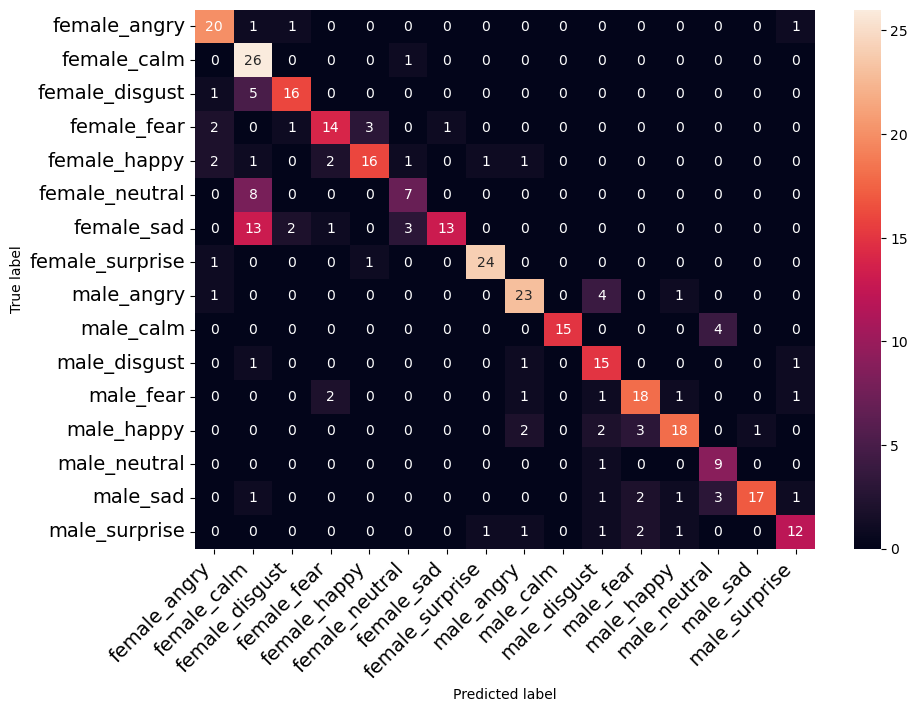

In [5]:
results = get_results(model_history,model,X_test,y_test, ref.labels.unique())
results.create_plot(model_history)
results.create_results(model)
results.confusion_results(X_test, y_test, ref.labels.unique(), model)

In [8]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_CNN2D.h5")
print("Loaded model from disk")
# the optimiser
n=30
opt = optimizers.Adam(0.001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# Lets transform the dataset so we can apply the predictions
LoadData, sample_rate = librosa.load('test.wav'
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )


newdf = np.empty(shape=(1, n, 216, 1))
print(newdf.shape)
MFCC = librosa.feature.mfcc(LoadData, sr=sampling_rate, n_mfcc=n)
MFCC = np.expand_dims(MFCC, axis=2)
print(MFCC.shape)
newdf[0,] = MFCC
newpred = loaded_model.predict(newdf,batch_size=16,verbose=1)

newpred
filename = 'labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()


# Get the final predicted label
final = newpred.argmax(axis=1)
# final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(len(final)) #emo(final) #gender(final) 
print(final)

Loaded model from disk
(1, 36, 216, 1)
(36, 216, 1)


ValueError: in user code:

    File "/Users/owenhuynh/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/owenhuynh/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/owenhuynh/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/owenhuynh/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/owenhuynh/tensorflow-test/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/owenhuynh/tensorflow-test/env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 30, 216, 1), found shape=(None, 36, 216, 1)
